# Analysis of electricity generated by solar panels

## Table of contents
1. [Read the dataset and print basic statistics](#read)
2. Plots
  1. [Daily production mean (7-day moving avergage)](#7dma)
  1. [Year over year comparison](#yoy)
  1. [Daily spike mean](#spike)
  1. [Yearly production](#yearly)
  1. [Monthly production](#monthly)
  1. [Yearly cumulative production](#yearly_cum)  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
'''
FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
  '''
pd.plotting.register_matplotlib_converters()

DATE_FORMAT = "%d/%m/%Y"
DATA_FILE_NAME = "TL001_01.CSV"

## Read the dataset and print basic statistics <a name="read"></a>

In [3]:
df = pd.read_csv(DATA_FILE_NAME,
                 skiprows=1, # 'SerialNr.: XYZ'
                 usecols=[0, 1, 5], # only use Date, Time, Energy [Ws]
                 sep=';').dropna().set_index('Date')
'''
df['Inverter No.'].unique()
Out[16]: array([1], dtype=int64)

df['Device Type'].unique()
Out[17]: array([190], dtype=int64)

df['Logging Periode [s]'].unique()
Out[18]:
array([428., 300., 299., 297., 469., 404., 320., 492., 484., 345., 497.,
       468., 354., 510., 454., 540., 456., 521., 490., 396., 311., 418.,
       317., 322., 397., 376., 439., 352., 385., 393., 386., 465., 366.,
       394., 463., 461., 523., 514., 329., 398., 424., 407., 494., 305.,
       525., 319.])
'''
df.index = pd.to_datetime(df.index)
df['Energy [kWh]'] = df['Energy [Ws]'] / (1000 * 3600)
daily_production = df['Energy [kWh]'].groupby(level=0).sum()
start_day = df.index[0]
end_day = df.index[-1]
print(f'Data from {start_day.strftime(DATE_FORMAT)} to '
                f'{end_day.strftime(DATE_FORMAT)}, '
                f'{(end_day-start_day).days + 1:,} days, '
                f'{df.shape[0]:,} records')
print(f"Max spike {df['Energy [kWh]'].max():0>5.2f} kWh "
      f"at {df[df['Energy [kWh]'] == df['Energy [kWh]'].max()].index.strftime(DATE_FORMAT)[0]} "
      f"{df[df['Energy [kWh]'] == df['Energy [kWh]'].max()]['Time'][0]}")
print(f'Max daily {daily_production.max():0>5.2f} kWh '
      f'on {daily_production.idxmax().strftime(DATE_FORMAT)}')
print(f'Min daily {daily_production.min():0>5.2f} kWh '
      f'on {daily_production.idxmin().strftime(DATE_FORMAT)}')
print(f'Total production {daily_production.sum():0>5,.0f} kWh')
for year in range(start_day.year, end_day.year+1):
    print(f'{year} production {daily_production[str(year)].sum():0>5,.0f} kWh')

Data from 22/05/2012 to 31/12/2020, 3,146 days, 422,730 records
Max spike 00.36 kWh at 13/05/2014 09:55:00
Max daily 19.75 kWh on 04/05/2014
Min daily 00.00 kWh on 21/07/2015
Total production 28,910 kWh
2012 production 2,272 kWh
2013 production 3,334 kWh
2014 production 3,259 kWh
2015 production 3,421 kWh
2016 production 3,420 kWh
2017 production 3,544 kWh
2018 production 3,276 kWh
2019 production 3,306 kWh
2020 production 3,078 kWh


## Daily production mean (7-day moving avergage) <a name="7dma"></a>

Date
2013-02-12    0.0
2014-03-18    0.0
2014-03-19    0.0
2014-11-05    0.0
2014-11-06    0.0
2015-07-22    0.0
2015-07-23    0.0
2015-07-24    0.0
2015-07-25    0.0
2015-07-26    0.0
2015-07-27    0.0
2015-07-28    0.0
2015-07-29    0.0
2015-07-30    0.0
2017-12-11    0.0
2019-04-14    0.0
2019-04-15    0.0
2020-04-13    0.0
2020-04-14    0.0
2020-04-15    0.0
2020-04-16    0.0
2020-04-17    0.0
2020-04-18    0.0
2020-04-19    0.0
2020-04-20    0.0
2020-04-21    0.0
2020-04-22    0.0
2020-04-23    0.0
2020-04-24    0.0
2020-04-25    0.0
2020-04-26    0.0
2020-04-27    0.0
2020-04-28    0.0
2020-04-29    0.0
2020-04-30    0.0
2020-05-01    0.0
2020-05-02    0.0
2020-05-03    0.0
2020-05-04    0.0
2020-05-05    0.0
2020-05-06    0.0
2020-05-07    0.0
2020-05-08    0.0
2020-12-02    0.0
2020-12-28    0.0
2020-12-29    0.0
Name: Energy [kWh], dtype: float64
Removed data for 29/02/2016
Removed data for 29/02/2020


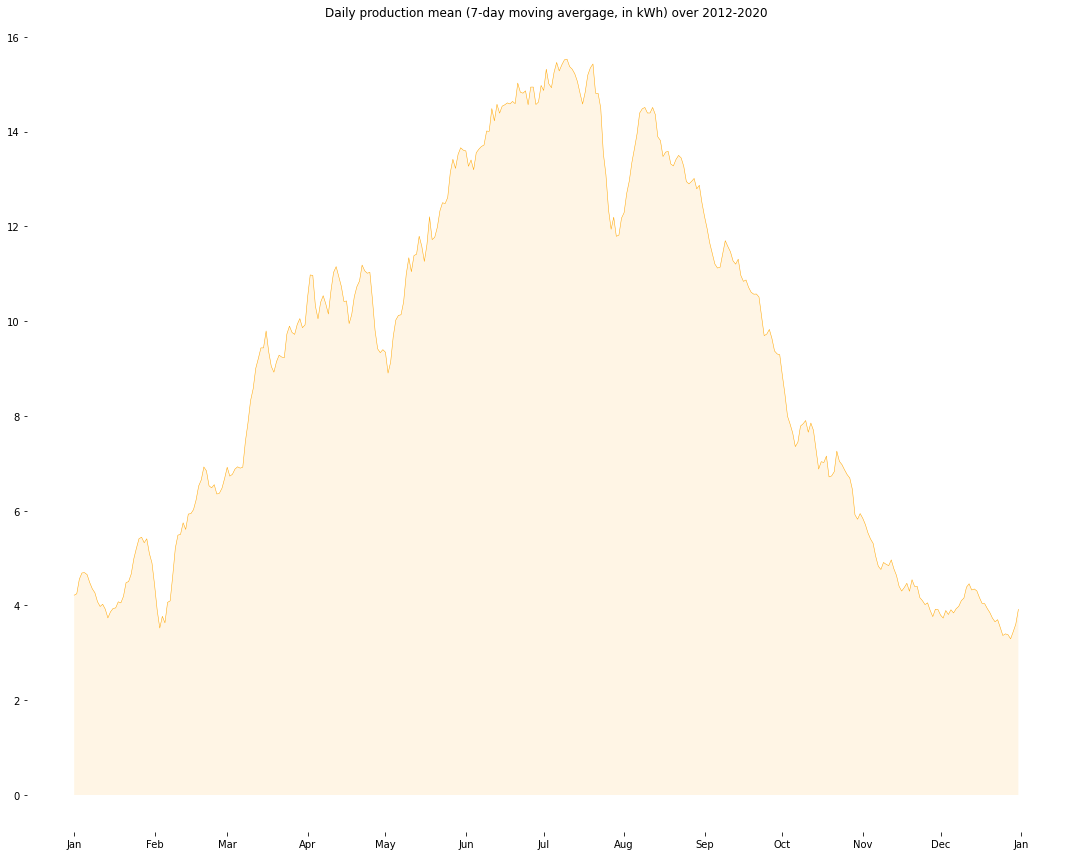

In [4]:
# Find days with no production: resample to daily interval to have all days
daily_production = daily_production.resample('D').mean().fillna(0)
print(daily_production[daily_production == 0])

# aggregate data per year and per month (before removing the leap days!)
yearly_production = {}
yearly_cumulative = {}
monthly_production = {}
for year in range(start_day.year, end_day.year+1):
    yearly_production[str(year)] = daily_production[str(year)].sum()
    yearly_cumulative[str(year)] = daily_production[str(year)].cumsum()
    for month in range(1, 13):
        if year == start_day.year:
            if month >= start_day.month:
                monthly_production[f'{year}-{month:02}'] = daily_production[f'{year}-{month:02}'].sum()
        elif year == end_day.year:
            if month <= end_day.month:
                monthly_production[f'{year}-{month:02}'] = daily_production[f'{year}-{month:02}'].sum()
        else:
            monthly_production[f'{year}-{month:02}'] = daily_production[f'{year}-{month:02}'].sum()

# remove leap days on the complete dataset and the daily_production
for year in range(start_day.year if start_day.month<3 else start_day.year+1,
                  end_day.year+1 if end_day.month>2 else end_day.year):
    if pd.Timestamp(year, 2, 28).is_leap_year: # can't use 29.02, would cause [ValueError: day is out of range for month] for non-leap years!
        try:
            daily_production.drop(datetime(year, 2, 29), inplace=True)
            df.drop(datetime(year, 2, 29), inplace=True)
            yearly_cumulative[str(year)].drop(datetime(year, 2, 29), inplace=True)
        except:
            print(f'WARNING: cannot find data for {datetime(year, 2, 29).strftime(DATE_FORMAT)}')
        else:
            print(f'Removed data for {datetime(year, 2, 29).strftime(DATE_FORMAT)}')

daily_production_mean = daily_production.copy()
daily_production_mean.index = daily_production_mean.index.strftime("%m-%d")
# use the 7-day moving average to smooth data
daily_production_mean = daily_production_mean.rolling(7, min_periods=5).mean()
daily_production_mean = daily_production_mean.groupby(level=0).mean()

daily_production_min = daily_production.copy()
daily_production_min.index = daily_production_min.index.strftime("%m-%d")
daily_production_min = daily_production_min.groupby(level=0).min()

daily_production_max = daily_production.copy()
daily_production_max.index = daily_production_max.index.strftime("%m-%d")
daily_production_max = daily_production_max.groupby(level=0).max()

dates = list()
dates.append(datetime.strptime('2019-01-01', '%Y-%m-%d'))
for d in range(1, 365):
    dates.append(dates[0] + timedelta(days = d))

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(dates, daily_production_mean, label='Mean daily production',
        c='orange', linewidth=0.5)

ax.fill_between(dates, daily_production_mean,
                              np.zeros(len(daily_production_mean)),
                       facecolor='orange',
                       alpha=0.1) # transparency, 1=normal, 0=invisible

plt.title(f'Daily production mean (7-day moving avergage, in kWh) over {start_day.year}-{end_day.year}')
plt.box(False) # remove the frame
# set dates limits
#ax.set_xlim([dates[0], dates[-1]]) # remove the Jan on the right
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()

## Year over year comparison <a name="yoy"></a>

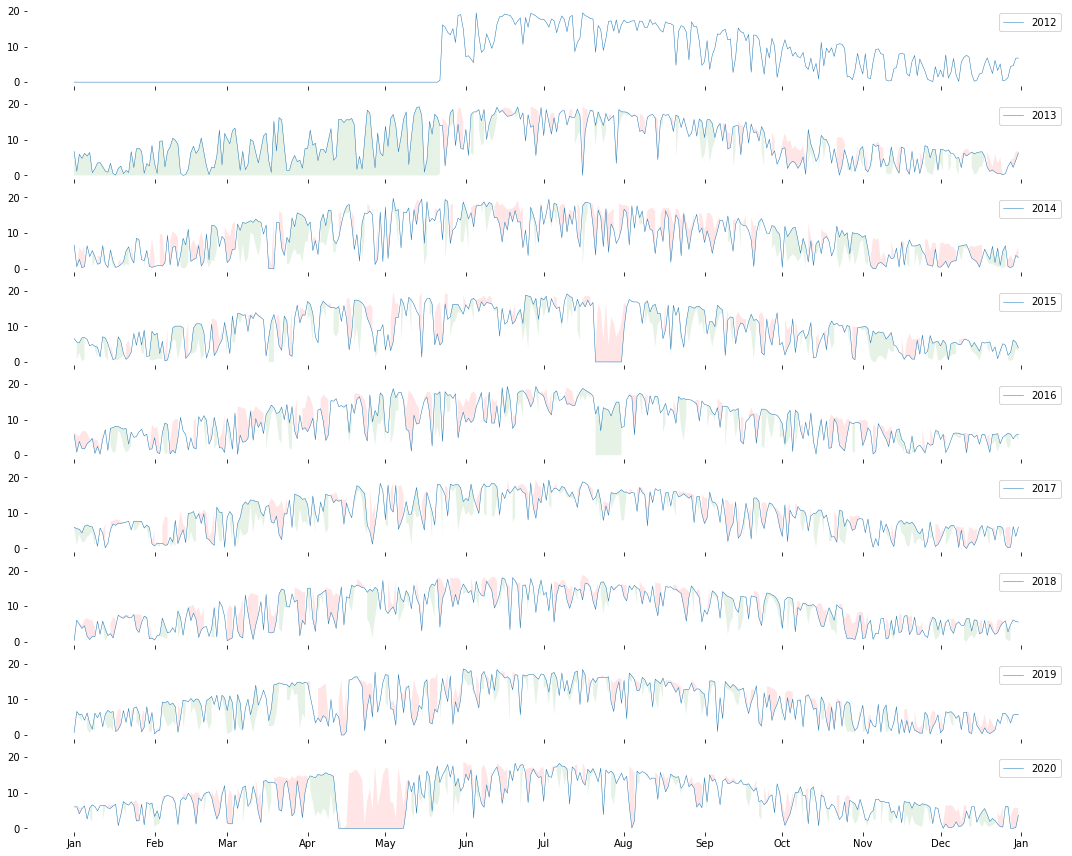

In [5]:
# plot everything year by year
years_to_display = range(start_day.year, end_day.year+1)
fig, axs = plt.subplots(len(years_to_display), 1, sharey=True, sharex=True, figsize=(15, 12))
# create a non-leap one year interval
year_template = start_day.year+1 if start_day.is_leap_year else start_day.year.year
dates = list()
dates.append(datetime.strptime(f'{year_template}-01-01', '%Y-%m-%d'))
for d in range(1, 365):
    dates.append(dates[0] + timedelta(days = d))
# create a dict for the data to plot, in order to get easier access to previous
# year data
data_to_plot = {}
for year in years_to_display:
    ax = axs[year - start_day.year]
    # dates is always a 365-day array, so if this is the first or last year,
    # we need to pad the data series with zeros to match the size
    data_to_plot[f'{year}'] = daily_production[f'{year}']
    # reset the index so that later we can compare different years. Otherwise,
    # would get ValueError: Can only compare identically-labeled Series objects
    data_to_plot[f'{year}'].reset_index(drop=True, inplace=True)
    if year == start_day.year:
        data_to_plot[f'{year}'] = np.append(np.zeros(365-len(data_to_plot[f'{year}'])),
                                            data_to_plot[f'{year}'])
    elif year == end_day.year:
        data_to_plot[f'{year}'] = np.append(data_to_plot[f'{year}'],
                                            np.zeros(365-len(data_to_plot[f'{year}'])))
    ax.plot(dates, data_to_plot[f'{year}'], label=f'{year}', linewidth=0.5)
    ax.legend()
    # remove the frames of this subplot
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_visible(False)
    if year > start_day.year:
        better_than_previous_year = data_to_plot[f'{year-1}'] < data_to_plot[f'{year}']
        ax.fill_between(dates, data_to_plot[f'{year-1}'],
                        data_to_plot[f'{year}'],
                        where=better_than_previous_year,
                        facecolor='green', alpha=0.1)
        ax.fill_between(dates, data_to_plot[f'{year-1}'],
                        data_to_plot[f'{year}'],
                        where=~better_than_previous_year, # negate the Series
                        facecolor='red', alpha=0.1)

#ax.set_xlim([dates[0], dates[-1]]) # remove the Jan on the right
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
fig.canvas.draw()
plt.tight_layout()

## Daily spike mean <a name="spike"></a>

Removed data for 29/02/2016
Removed data for 29/02/2020


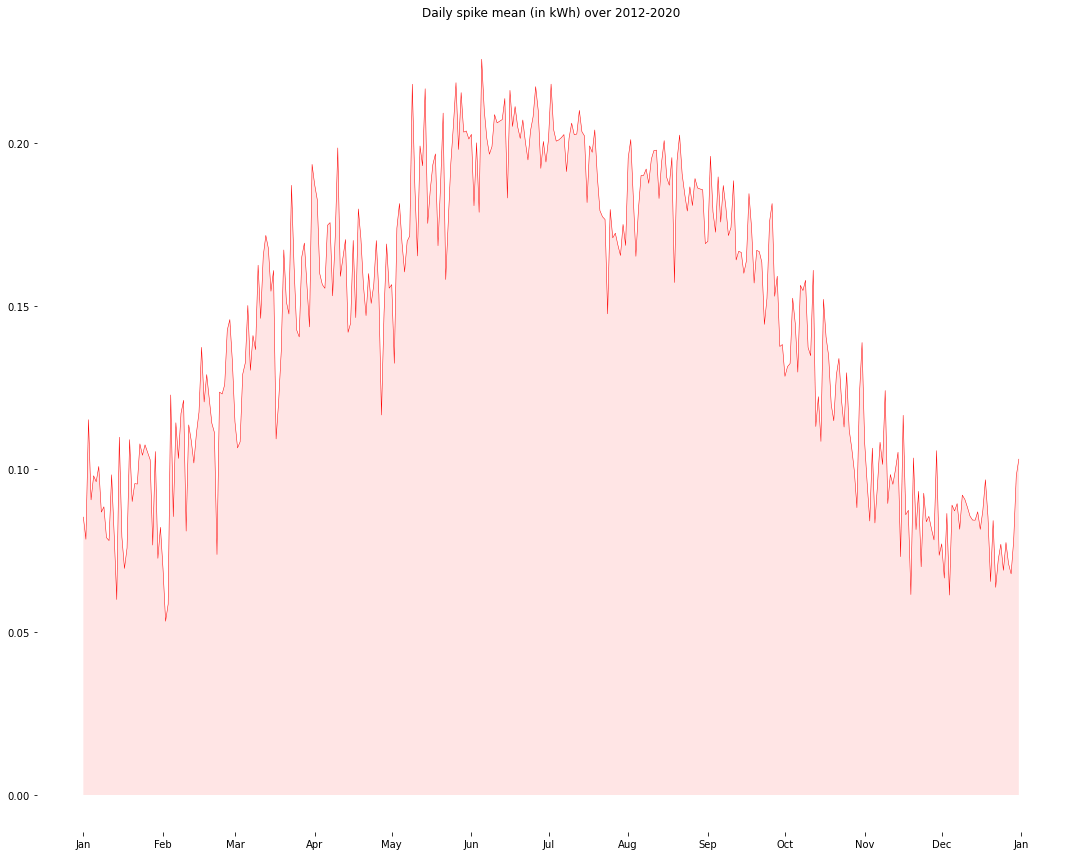

In [6]:
# consider the best interval of the day
daily_spike = df['Energy [kWh]'].groupby(level=0).max()
daily_spike = daily_spike.resample('D').mean().fillna(0)
# remove leap days on daily_spike (the resampling reintroduces it!)
for year in range(start_day.year if start_day.month<3 else start_day.year+1,
                  end_day.year+1 if end_day.month>2 else end_day.year):
    if pd.Timestamp(year, 2, 28).is_leap_year: # can't use 29.02, would cause [ValueError: day is out of range for month] for non-leap years!
        try:
            daily_spike.drop(datetime(year, 2, 29), inplace=True)
        except:
            print(f'WARNING: cannot find data for {datetime(year, 2, 29).strftime(DATE_FORMAT)}')
        else:
            print(f'Removed data for {datetime(year, 2, 29).strftime(DATE_FORMAT)}')

daily_spike_mean = daily_spike
daily_spike_mean.index = daily_spike_mean.index.strftime("%m-%d")
daily_spike_mean = daily_spike_mean.groupby(level=0).mean()

fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(dates, daily_spike_mean, label='Daily spike mean',
        c='red', linewidth=0.5)

ax.fill_between(dates, daily_spike_mean,
                              np.zeros(len(daily_spike_mean)),
                       facecolor='red',
                       alpha=0.1) # transparency, 1=normal, 0=invisible

plt.title(f'Daily spike mean (in kWh) over {start_day.year}-{end_day.year}')
plt.box(False)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()

## Yearly production <a name="yearly"></a>

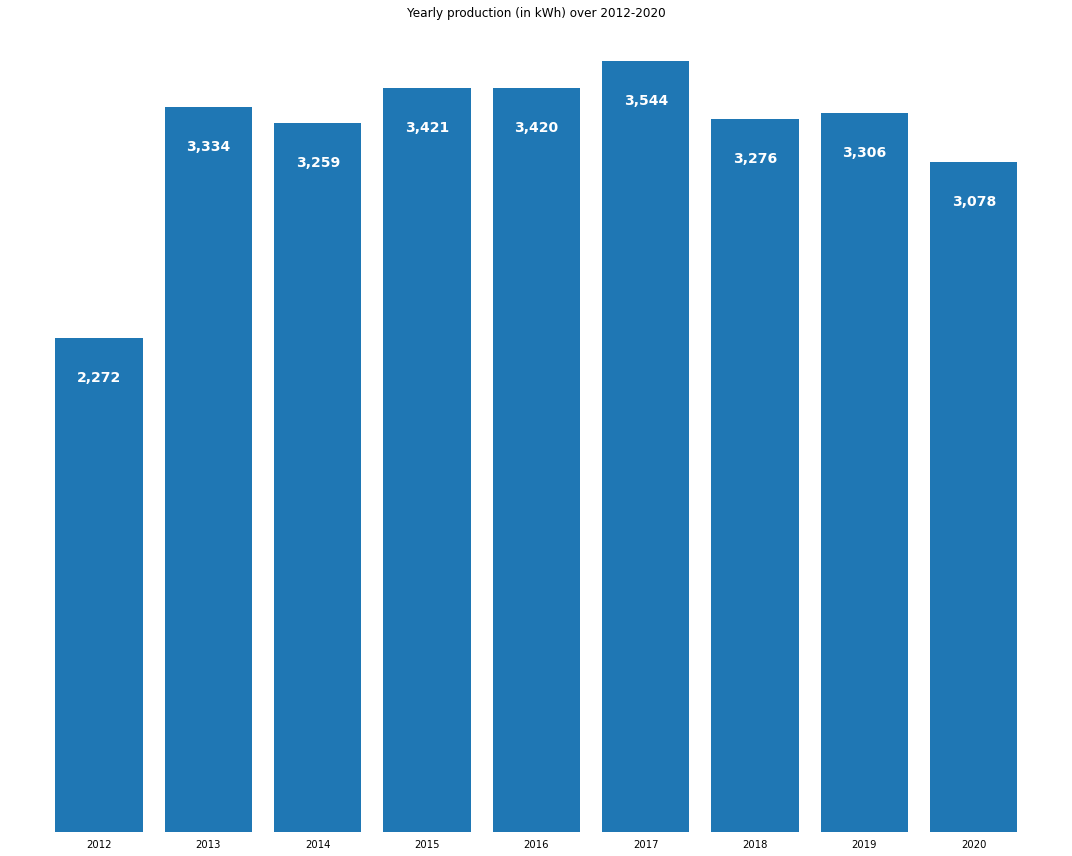

In [7]:
# plot yearly and monthly production
series_yearly_production = pd.Series(yearly_production)
fig, ax = plt.subplots(figsize=(15, 12))
ax.bar(series_yearly_production.index, series_yearly_production)
# remove all ticks and the y labels
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=True)
# add values directly in the bar
for i, v in enumerate(series_yearly_production):
    plt.text(i, v-200, f'{v:,.0f}', color='white', fontweight='bold',
             fontsize=14, ha='center') # ha is horizontalalignment
plt.title(f'Yearly production (in kWh) over {start_day.year}-{end_day.year}')
plt.box(False)
plt.tight_layout()

## Monthly production <a name="monthly"></a>

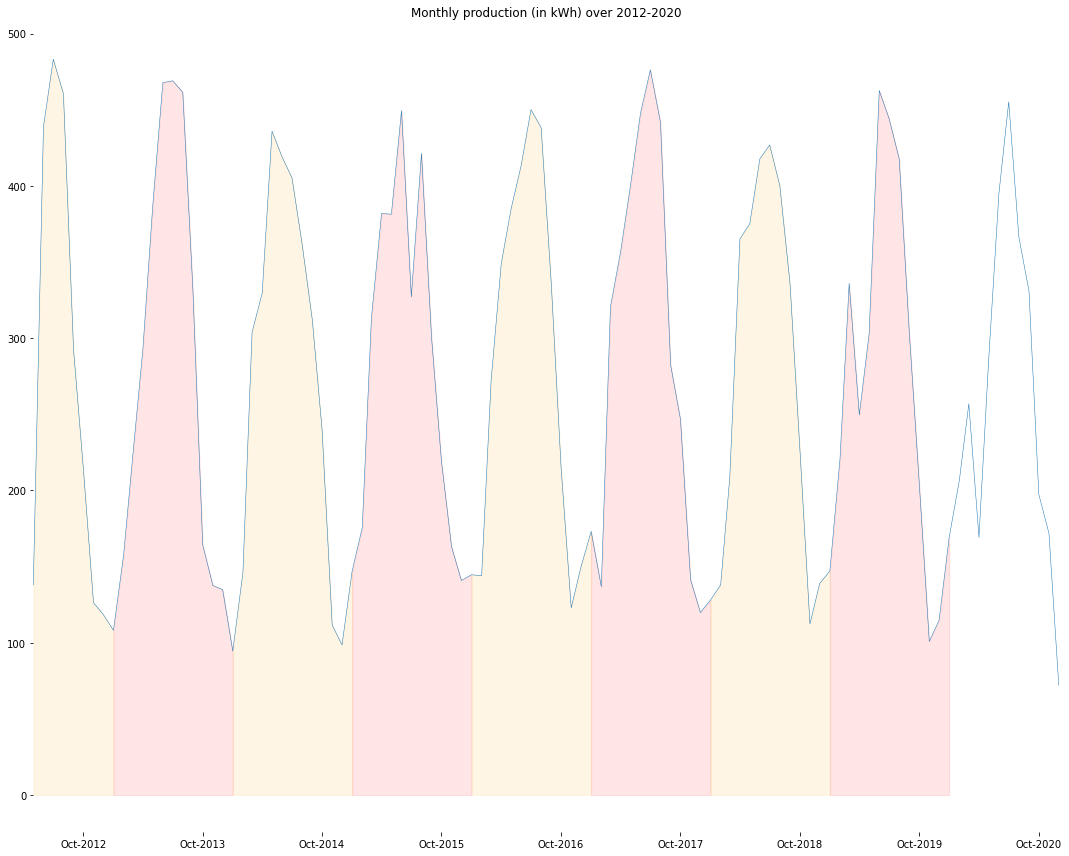

In [8]:
series_monthly_production = pd.Series(monthly_production)
series_monthly_production.index = pd.to_datetime(series_monthly_production.index)
fig, ax = plt.subplots(figsize=(15, 12))
ax.plot(series_monthly_production.index, series_monthly_production,
        linewidth=0.5)
plt.title(f'Monthly production (in kWh) over {start_day.year}-{end_day.year}')
plt.box(False)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# alternate the color when changing year
current_year = start_day.year
base_idx = 0
for month_idx in range(series_monthly_production.size):
    if series_monthly_production.index[month_idx].year > current_year:
        ax.fill_between(series_monthly_production.index[base_idx:month_idx+1],
                 np.zeros(len(series_monthly_production[base_idx:month_idx+1])),
                 series_monthly_production[base_idx:month_idx+1],
                       color='red' if current_year % 2 else 'orange',
                       alpha=0.1)
        current_year = series_monthly_production.index[month_idx].year
        base_idx = month_idx
ax.set_xlim([series_monthly_production.index[0], series_monthly_production.index[-1]])
plt.tight_layout()

## Yearly cumulative production <a name="yearly_cum"></a>

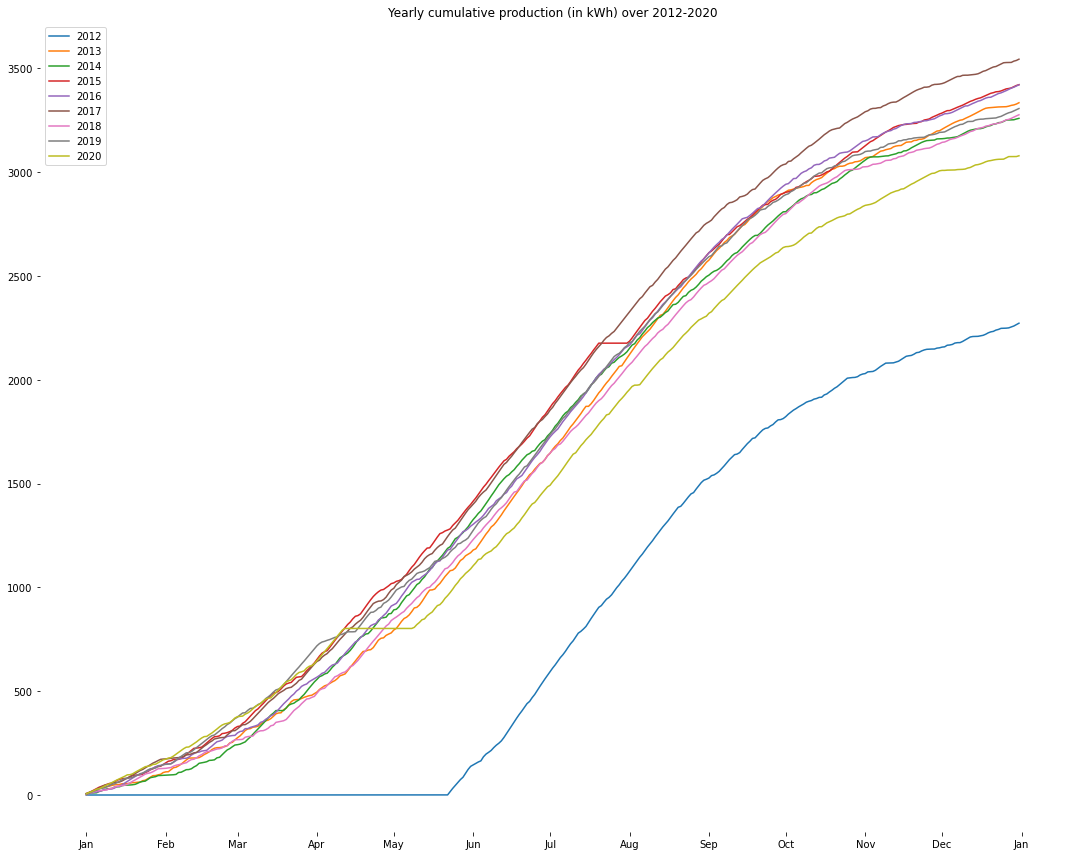

In [9]:
# plot everything year by year
years_to_display = range(start_day.year, end_day.year+1)
fig, ax = plt.subplots(figsize=(15, 12))
for year in years_to_display:
    if year == start_day.year:
        yearly_cumulative[f'{year}'] = np.append(np.zeros(365-len(yearly_cumulative[f'{year}'])),
                                            yearly_cumulative[f'{year}'])
    elif year == end_day.year:
        yearly_cumulative[f'{year}'] = np.append(yearly_cumulative[f'{year}'],
                                            np.zeros(365-len(yearly_cumulative[f'{year}'])))
    ax.plot(dates, yearly_cumulative[f'{year}'], label=f'{year}')#, linewidth=0.5)
    ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.title(f'Yearly cumulative production (in kWh) over {start_day.year}-{end_day.year}')
plt.box(False)
plt.tight_layout()